 Tsanas - Accurate telemonitoring of Parkinson's disease progression

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


In [176]:
# ============================================
# LEITURA DO DATASET LOCAL (VS CODE / JUPYTER)
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Caminho para o arquivo CSV (ajuste conforme a pasta onde está salvo)
# Exemplo: se o arquivo está na mesma pasta do notebook:
file_path = "parkinsons_updrs.csv"

# Se estiver em uma subpasta, por exemplo "data/demencia.csv":
# file_path = os.path.join("data", "demencia.csv")

# Ler o CSV
df = pd.read_csv(
    "parkinsons_updrs.csv",# não tem header no arquivo    
)


# Mostrar informações básicas
print("✅ Dataset carregado com sucesso!")
print(f"Formato: {df.shape}")
print(f"Colunas: {list(df.columns)[:10]} ...")


✅ Dataset carregado com sucesso!
Formato: (5875, 22)
Colunas: ['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5'] ...


In [177]:
df = df.replace([np.inf, -np.inf], np.nan).dropna()
print(f"✅ Dataset limpo: {df.shape[0]} linhas restantes")


✅ Dataset limpo: 5875 linhas restantes


# Nova seção

In [178]:
print("Colunas disponíveis:")
print(df.columns.tolist())

# Alvos
target_motor = "motor_UPDRS"
target_total = "total_UPDRS"

# Features (exclui ID, idade, sexo, tempo e targets)
exclude = ["subject#", "age", "sex", "test_time", target_motor, target_total]
features = [c for c in df.columns if c not in exclude]

print("\nFeatures de voz (dysphonia measures):")
print(features)
df[features].describe().T


Colunas disponíveis:
['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']

Features de voz (dysphonia measures):
['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']


,count,mean,std,min,25%,50%,75%,max
Jitter(%),5875.0,0.006154,0.005624,0.000830,0.003580,0.004900,0.006800,0.099990
Jitter(Abs),5875.0,0.000044,0.000036,0.000002,0.000022,0.000035,0.000053,0.000446
Jitter:RAP,5875.0,0.002987,0.003124,0.000330,0.001580,0.002250,0.003290,0.057540
Jitter:PPQ5,5875.0,0.003277,0.003732,0.000430,0.001820,0.002490,0.003460,0.069560
Jitter:DDP,5875.0,0.008962,0.009371,0.000980,0.004730,0.006750,0.009870,0.172630
Shimmer,5875.0,0.034035,0.025835,0.003060,0.019120,0.027510,0.039750,0.268630
Shimmer(dB),5875.0,0.310960,0.230254,0.026000,0.175000,0.253000,0.365000,2.107000
Shimmer:APQ3,5875.0,0.017156,0.013237,0.001610,0.009280,0.013700,0.020575,0.162670
Shimmer:APQ5,5875.0,0.020144,0.016664,0.001940,0.010790,0.015940,0.023755,0.167020
Shimmer:APQ11,5875.0,0.027481,0.019986,0.002490,0.015665,0.022710,0.032715,0.275460


In [179]:
corr_motor = df[features].corrwith(df[target_motor], method="spearman")
corr_total = df[features].corrwith(df[target_total], method="spearman")

print("Correlação Spearman com motor_UPDRS:")
print(corr_motor.sort_values(ascending=False).head(10))

print("\nCorrelação Spearman com total_UPDRS:")
print(corr_total.sort_values(ascending=False).head(10))


Correlação Spearman com motor_UPDRS:
Shimmer:APQ11    0.163761
PPE              0.163229
Shimmer(dB)      0.140127
Shimmer          0.136186
NHR              0.135626
Jitter(%)        0.127905
Shimmer:APQ5     0.121267
Jitter:PPQ5      0.120092
RPDE             0.117980
Shimmer:DDA      0.113785
dtype: float64

Correlação Spearman com total_UPDRS:
Shimmer:APQ11    0.161151
PPE              0.155236
RPDE             0.149926
NHR              0.143972
Shimmer(dB)      0.139915
Shimmer          0.137550
Jitter(%)        0.129237
Shimmer:APQ5     0.124940
Shimmer:DDA      0.119912
Shimmer:APQ3     0.119909
dtype: float64


In [180]:
# ============================================
# Etapa 0 – Preparação
# ============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt


In [181]:
cols = [
    "subject#", "age", "sex", "test_time", "motor_UPDRS", "total_UPDRS",
    "Jitter(%)", "Jitter(Abs)", "Jitter:RAP", "Jitter:PPQ5", "Jitter:DDP",
    "Shimmer", "Shimmer(dB)", "Shimmer:APQ3", "Shimmer:APQ5",
    "Shimmer:APQ11", "Shimmer:DDA", "NHR", "HNR", "RPDE", "DFA", "PPE"
]

df = pd.read_csv(
    "parkinsons_updrs.csv",
    header=None,      # não tem header no arquivo
    names=cols,     
)

# Converter tudo para numérico
df = df.apply(pd.to_numeric, errors="coerce")

print(df.dtypes)
print(df.head())


subject#         float64
age              float64
sex              float64
test_time        float64
motor_UPDRS      float64
total_UPDRS      float64
Jitter(%)        float64
Jitter(Abs)      float64
Jitter:RAP       float64
Jitter:PPQ5      float64
Jitter:DDP       float64
Shimmer          float64
Shimmer(dB)      float64
Shimmer:APQ3     float64
Shimmer:APQ5     float64
Shimmer:APQ11    float64
Shimmer:DDA      float64
NHR              float64
HNR              float64
RPDE             float64
DFA              float64
PPE              float64
dtype: object
   subject#   age  sex  test_time  motor_UPDRS  total_UPDRS  Jitter(%)  \
0       NaN   NaN  NaN        NaN          NaN          NaN        NaN   
1       1.0  72.0  0.0     5.6431       28.199       34.398    0.00662   
2       1.0  72.0  0.0    12.6660       28.447       34.894    0.00300   
3       1.0  72.0  0.0    19.6810       28.695       35.389    0.00481   
4       1.0  72.0  0.0    25.6470       28.905       35.810    0.0

In [182]:
# ============================================
# 0️⃣ INTERPOLAR UPDRS (por paciente, linear)
# ============================================

df_interp = []

for pid, group in df.groupby("subject#"):
    group = group.sort_values("test_time")
    # Interpolação linear suave
    group["motor_UPDRS_interp"] = np.interp(
        group["test_time"], group["test_time"], group["motor_UPDRS"]
    )
    group["total_UPDRS_interp"] = np.interp(
        group["test_time"], group["test_time"], group["total_UPDRS"]
    )
    df_interp.append(group)

df = pd.concat(df_interp, ignore_index=True)

print("✅ Colunas 'motor_UPDRS_interp' e 'total_UPDRS_interp' criadas com sucesso!")


✅ Colunas 'motor_UPDRS_interp' e 'total_UPDRS_interp' criadas com sucesso!


In [183]:
# ============================================
# 1️⃣ NORMALIZAÇÃO POR PACIENTE
# ============================================

dysphonia = [
    "Jitter(%)", "Jitter(Abs)", "Jitter:RAP", "Jitter:PPQ5", "Jitter:DDP",
    "Shimmer", "Shimmer(dB)", "Shimmer:APQ3", "Shimmer:APQ5",
    "Shimmer:APQ11", "Shimmer:DDA", "NHR", "HNR", "RPDE", "DFA", "PPE"
]

df_norm = df.copy()
for pid, group in df.groupby("subject#"):
    df_norm.loc[group.index, dysphonia] = (
        (group[dysphonia] - group[dysphonia].mean()) / group[dysphonia].std()
    )

print("✅ Normalização por paciente concluída.")

df = df.apply(pd.to_numeric, errors="ignore")
corr_motor = df[dysphonia].corrwith(df["motor_UPDRS"], method="spearman")
corr_total = df[dysphonia].corrwith(df["total_UPDRS"], method="spearman")

print("Correlação Spearman com motor_UPDRS:\n", corr_motor)
print("\nCorrelação Spearman com total_UPDRS:\n", corr_total)


✅ Normalização por paciente concluída.
Correlação Spearman com motor_UPDRS:
 Jitter(%)        0.127905
Jitter(Abs)      0.072467
Jitter:RAP       0.106679
Jitter:PPQ5      0.120092
Jitter:DDP       0.106731
Shimmer          0.136186
Shimmer(dB)      0.140127
Shimmer:APQ3     0.113784
Shimmer:APQ5     0.121267
Shimmer:APQ11    0.163761
Shimmer:DDA      0.113785
NHR              0.135626
HNR             -0.158061
RPDE             0.117980
DFA             -0.131377
PPE              0.163229
dtype: float64

Correlação Spearman com total_UPDRS:
 Jitter(%)        0.129237
Jitter(Abs)      0.104178
Jitter:RAP       0.109214
Jitter:PPQ5      0.118347
Jitter:DDP       0.109251
Shimmer          0.137550
Shimmer(dB)      0.139915
Shimmer:APQ3     0.119909
Shimmer:APQ5     0.124940
Shimmer:APQ11    0.161151
Shimmer:DDA      0.119912
NHR              0.143972
HNR             -0.162284
RPDE             0.149926
DFA             -0.141538
PPE              0.155236
dtype: float64


/var/folders/tk/8h9c02552k389khjxlk1mh9h0000gn/T/ipykernel_32553/3006102507.py:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


Correlação Spearman com motor_UPDRS:
 Jitter(%)        0.127905
Jitter(Abs)      0.072467
Jitter:RAP       0.106679
Jitter:PPQ5      0.120092
Jitter:DDP       0.106731
Shimmer          0.136186
Shimmer(dB)      0.140127
Shimmer:APQ3     0.113784
Shimmer:APQ5     0.121267
Shimmer:APQ11    0.163761
Shimmer:DDA      0.113785
NHR              0.135626
HNR             -0.158061
RPDE             0.117980
DFA             -0.131377
PPE              0.163229
dtype: float64

Correlação Spearman com total_UPDRS:
 Jitter(%)        0.129237
Jitter(Abs)      0.104178
Jitter:RAP       0.109214
Jitter:PPQ5      0.118347
Jitter:DDP       0.109251
Shimmer          0.137550
Shimmer(dB)      0.139915
Shimmer:APQ3     0.119909
Shimmer:APQ5     0.124940
Shimmer:APQ11    0.161151
Shimmer:DDA      0.119912
NHR              0.143972
HNR             -0.162284
RPDE             0.149926
DFA             -0.141538
PPE              0.155236
dtype: float64


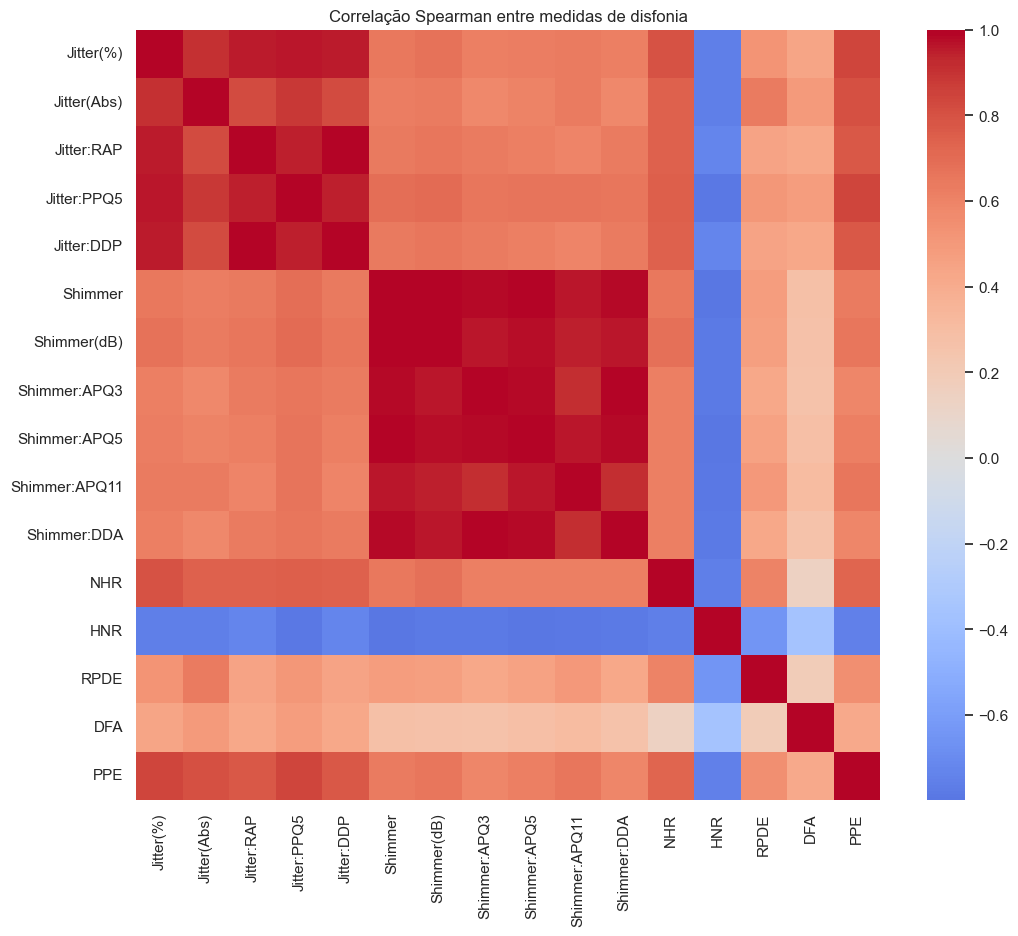

In [184]:
# Selecionar apenas as 16 medidas de disfonia
dysphonia = [
    "Jitter(%)", "Jitter(Abs)", "Jitter:RAP", "Jitter:PPQ5", "Jitter:DDP",
    "Shimmer", "Shimmer(dB)", "Shimmer:APQ3", "Shimmer:APQ5",
    "Shimmer:APQ11", "Shimmer:DDA", "NHR", "HNR", "RPDE", "DFA", "PPE"
]

# Correlação Spearman entre medidas e UPDRS
corr_motor = df[dysphonia].corrwith(df["motor_UPDRS"], method="spearman")
corr_total = df[dysphonia].corrwith(df["total_UPDRS"], method="spearman")

print("Correlação Spearman com motor_UPDRS:\n", corr_motor)
print("\nCorrelação Spearman com total_UPDRS:\n", corr_total)

# Correlação entre as próprias medidas
corr_matrix = df[dysphonia].corr(method="spearman")

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Correlação Spearman entre medidas de disfonia")
plt.show()


In [185]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

# Targets interpolados
y_motor = df_norm["motor_UPDRS_interp"].values
y_total = df_norm["total_UPDRS_interp"].values
X = df_norm[dysphonia].values

# Regressão Linear (LS)
ls_model = LinearRegression()

# IRLS — usando statsmodels WLS para replicar a ponderação iterativa real
def fit_irls(X, y, max_iter=50, tol=1e-6):
    w = np.ones(len(y))
    for _ in range(max_iter):
        model = sm.WLS(y, sm.add_constant(X), weights=w).fit()
        resid = np.abs(y - model.predict(sm.add_constant(X)))
        new_w = 1 / (1 + resid)
        if np.allclose(w, new_w, atol=tol):
            break
        w = new_w
    return model

# LASSO
lasso_model = Lasso(alpha=0.001, max_iter=10000)


In [186]:
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error

rkf = RepeatedKFold(n_splits=10, n_repeats=100, random_state=42)

def eval_model_cv(model_type, X, y):
    maes = []
    for train, test in rkf.split(X):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        if model_type == 'LS':
            m = LinearRegression().fit(X_train, y_train)
            y_pred = m.predict(X_test)
        elif model_type == 'IRLS':
            m = fit_irls(X_train, y_train)
            y_pred = m.predict(sm.add_constant(X_test))
        elif model_type == 'LASSO':
            m = Lasso(alpha=0.001, max_iter=10000).fit(X_train, y_train)
            y_pred = m.predict(X_test)

        maes.append(mean_absolute_error(y_test, y_pred))
    return np.mean(maes), np.std(maes)


In [187]:
print("🔹 Motor UPDRS:")
mae_ls_m, sd_ls_m = eval_model_cv("LS", X, y_motor)
mae_irls_m, sd_irls_m = eval_model_cv("IRLS", X, y_motor)
mae_lasso_m, sd_lasso_m = eval_model_cv("LASSO", X, y_motor)
print(f"LS: MAE={mae_ls_m:.2f}±{sd_ls_m:.2f}")
print(f"IRLS: MAE={mae_irls_m:.2f}±{sd_irls_m:.2f}")
print(f"LASSO: MAE={mae_lasso_m:.2f}±{sd_lasso_m:.2f}")

print("\n🔹 Total UPDRS:")
mae_ls_t, sd_ls_t = eval_model_cv("LS", X, y_total)
mae_irls_t, sd_irls_t = eval_model_cv("IRLS", X, y_total)
mae_lasso_t, sd_lasso_t = eval_model_cv("LASSO", X, y_total)
print(f"LS: MAE={mae_ls_t:.2f}±{sd_ls_t:.2f}")
print(f"IRLS: MAE={mae_irls_t:.2f}±{sd_irls_t:.2f}")
print(f"LASSO: MAE={mae_lasso_t:.2f}±{sd_lasso_t:.2f}")


🔹 Motor UPDRS:


/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.441e+01, tolerance: 3.466e+01
  model = cd_fast.enet_coordinate_descent(
/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.114e+01, tolerance: 3.489e+01
  model = cd_fast.enet_coordinate_descent(
/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

LS: MAE=6.98±0.16
IRLS: MAE=6.99±0.16
LASSO: MAE=6.98±0.16

🔹 Total UPDRS:


/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.304e+01, tolerance: 6.019e+01
  model = cd_fast.enet_coordinate_descent(
/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e+02, tolerance: 6.034e+01
  model = cd_fast.enet_coordinate_descent(
/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

LS: MAE=8.68±0.24
IRLS: MAE=8.62±0.25
LASSO: MAE=8.68±0.24


In [188]:
# LS e LASSO
ls_full = LinearRegression().fit(X, y_motor)
lasso_full = Lasso(alpha=0.001, max_iter=10000).fit(X, y_motor)
irls_full = fit_irls(X, y_motor)

coef_table = pd.DataFrame({
    "Measure": dysphonia,
    "LS Coef": ls_full.coef_.round(2),
    "IRLS Coef": irls_full.params[1:].round(2),
    "LASSO Coef": lasso_full.coef_.round(2)
})

print("Tabela III — Coeficientes (Motor UPDRS):")
display(coef_table)
coef_table.to_csv("tabelaIII_motor.csv", index=False)


Tabela III — Coeficientes (Motor UPDRS):


,Measure,LS Coef,IRLS Coef,LASSO Coef
0,Jitter(%),-0.19,-0.44,-0.11
1,Jitter(Abs),0.23,0.36,0.19
2,Jitter:RAP,4.76,-6.50,0.02
3,Jitter:PPQ5,-0.07,-0.24,-0.05
4,Jitter:DDP,-4.68,6.74,0.00
5,Shimmer,0.01,0.71,-0.00
6,Shimmer(dB),0.16,-0.13,0.12
7,Shimmer:APQ3,-1.74,50.30,-0.07
8,Shimmer:APQ5,-0.04,0.42,-0.03
9,Shimmer:APQ11,-0.05,-0.10,-0.03


In [189]:
# Função para avaliar modelo com cross-validation repetida
rkf = RepeatedKFold(n_splits=10, n_repeats=100, random_state=123)

mae = make_scorer(mean_absolute_error, greater_is_better=False)

def eval_model(model, X, y):
    # Remover NaN e infinitos dentro da função
    X_ = X.replace([np.inf, -np.inf], np.nan).dropna()
    y_ = y[X_.index]  # manter alinhamento
    
    scores = cross_val_score(model, X_, y_, cv=rkf, scoring=mae, n_jobs=-1, error_score='raise')
    return -scores.mean(), scores.std()



In [190]:
X = df[dysphonia].copy()
y_motor = df["motor_UPDRS"].values
y_total = df["total_UPDRS"].values

models = {
    "LS (Linear)": Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())]),
    "IRLS (Huber)": Pipeline([("scaler", StandardScaler()), ("huber", HuberRegressor())]),
    "Lasso": Pipeline([("scaler", StandardScaler()), ("lasso", Lasso(alpha=0.001, max_iter=10000))])
}

for name, model in models.items():
    mae_m, sd_m = eval_model(model, X, y_motor)
    mae_t, sd_t = eval_model(model, X, y_total)
    print(f"{name}: MAE motor={mae_m:.2f}±{sd_m:.2f}, MAE total={mae_t:.2f}±{sd_t:.2f}")


LS (Linear): MAE motor=6.54±0.16, MAE total=8.34±0.23
IRLS (Huber): MAE motor=6.49±0.17, MAE total=8.22±0.24


/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.260e+02, tolerance: 3.484e+01
  model = cd_fast.enet_coordinate_descent(
/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.572e+01, tolerance: 6.032e+01
  model = cd_fast.enet_coordinate_descent(
/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

Lasso: MAE motor=6.54±0.16, MAE total=8.33±0.23


/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e+02, tolerance: 6.091e+01
  model = cd_fast.enet_coordinate_descent(


In [191]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# ================================
# LIMPEZA PARA OLS — REMOVER NaN e inf
# ================================
X_clean = X.replace([np.inf, -np.inf], np.nan)
mask = X_clean.notna().all(axis=1)  # máscara de linhas sem NaN
X_clean = X_clean[mask]
y_clean = y_motor[mask.values]      # aplica a mesma máscara no y

# Adicionar constante para o intercepto
X_ols = sm.add_constant(X_clean)

# ================================
# AJUSTAR MODELO OLS
# ================================
ols_model = sm.OLS(y_clean, X_ols).fit()

# Exibir resultados
print("AIC:", ols_model.aic)
print("BIC:", ols_model.bic)
print(ols_model.summary())


AIC: 40658.98146395826
BIC: 40772.51530672147
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     44.11
Date:                Sun, 26 Oct 2025   Prob (F-statistic):          1.22e-131
Time:                        01:34:40   Log-Likelihood:                -20312.
No. Observations:                5875   AIC:                         4.066e+04
Df Residuals:                    5858   BIC:                         4.077e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------


In [192]:
def best_cart_alpha(X, y):
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.model_selection import RepeatedKFold, cross_val_score
    from sklearn.metrics import make_scorer, mean_absolute_error
    import numpy as np

    alphas = [0.0, 1e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2]
    best_a, best_score = 0.0, -np.inf  # valor padrão seguro
    mae = make_scorer(mean_absolute_error, greater_is_better=False)
    rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

    X_ = X.replace([np.inf, -np.inf], np.nan).dropna()
    y_ = y[:len(X_)]  # garante alinhamento

    for a in alphas:
        try:
            tree = DecisionTreeRegressor(random_state=42, ccp_alpha=a, min_samples_leaf=5)
            s = cross_val_score(tree, X_, y_, cv=rkf, scoring=mae, n_jobs=-1).mean()
            if s > best_score:
                best_score, best_a = s, a
        except Exception as e:
            print(f"⚠️ Erro com alpha={a}: {e}")
            continue

    print(f"✅ Melhor alpha encontrado: {best_a:.5f} (score={best_score:.4f})")
    return best_a


In [193]:
subset6 = ["Jitter(Abs)", "Shimmer", "NHR", "HNR", "DFA", "PPE"]
# ============================================
# LIMPAR DADOS ANTES DE RODAR OS MODELOS
# ============================================
X6 = df[subset6].copy()
y_motor_clean = df["motor_UPDRS"].copy()
y_total_clean = df["total_UPDRS"].copy()

# Substitui infinitos por NaN e remove linhas com NaN em qualquer coluna
X6 = X6.replace([np.inf, -np.inf], np.nan)
mask = X6.notna().all(axis=1) & y_motor_clean.notna() & y_total_clean.notna()

# Aplica a máscara
X6 = X6[mask]
y_motor_clean = y_motor_clean[mask]
y_total_clean = y_total_clean[mask]

print(f"✅ Dados limpos: {X6.shape[0]} amostras restantes após remoção de NaN.")

# IRLS no subset
mae_m, sd_m = eval_model(models["IRLS (Huber)"], X6, y_motor_clean)

mae_t, sd_t = eval_model(models["IRLS (Huber)"], X6, y_total_clean)
print(f"IRLS (6 medidas): MAE motor={mae_m:.2f}±{sd_m:.2f}, MAE total={mae_t:.2f}±{sd_t:.2f}")

# CART no subset
alpha_m6 = best_cart_alpha(X6, y_motor)
alpha_t6 = best_cart_alpha(X6, y_total)
cart_m6 = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha_m6, min_samples_leaf=5)
cart_t6 = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha_t6, min_samples_leaf=5)

mae_m, sd_m = eval_model(cart_m6, X6, y_motor_clean)
mae_t, sd_t = eval_model(cart_t6, X6, y_total_clean)
print(f"CART (6 medidas): MAE motor={mae_m:.2f}±{sd_m:.2f}, MAE total={mae_t:.2f}±{sd_t:.2f}")


✅ Dados limpos: 5875 amostras restantes após remoção de NaN.
IRLS (6 medidas): MAE motor=6.59±0.16, MAE total=8.34±0.23
✅ Melhor alpha encontrado: 0.01000 (score=-6.4029)
✅ Melhor alpha encontrado: 0.01000 (score=-8.0978)
CART (6 medidas): MAE motor=6.37±0.22, MAE total=8.07±0.30


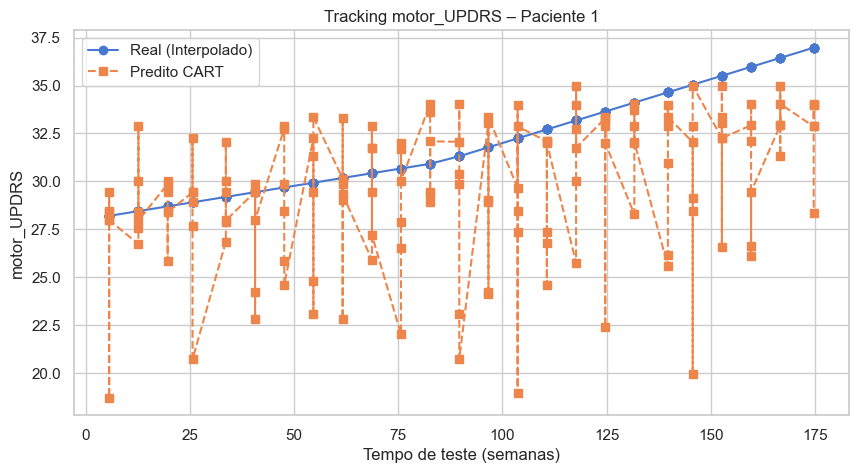

In [194]:
# Escolher um paciente qualquer
pid = 1
patient = df[df["subject#"] == pid]

# Corrigir alpha se None
if alpha_m6 is None or np.isnan(alpha_m6):
    alpha_m6 = 0.0


# Limpar e alinhar dados
X_model = X.replace([np.inf, -np.inf], np.nan)
mask = X_model.notna().all(axis=1) & pd.notna(y_motor_clean)
X_model = X_model[mask]
y_model = y_motor_clean[mask]

# Ajustar CART
cart = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha_m, min_samples_leaf=5)
cart.fit(X_model, y_model)

# Prever para o paciente
patient_pred = cart.predict(patient[dysphonia])

# Gráfico
plt.figure(figsize=(10,5))
plt.plot(patient["test_time"], patient["motor_UPDRS"], "o-", label="Real (Interpolado)")
plt.plot(patient["test_time"], patient_pred, "s--", label="Predito CART")
plt.title(f"Tracking motor_UPDRS – Paciente {pid}")
plt.xlabel("Tempo de teste (semanas)")
plt.ylabel("motor_UPDRS")
plt.legend()
plt.show()


# EDA


In [195]:
print(df.head())

   subject#   age  sex  test_time  motor_UPDRS  total_UPDRS  Jitter(%)  \
0       1.0  72.0  0.0     5.6431       28.199       34.398    0.00662   
1       1.0  72.0  0.0     5.6431       28.199       34.398    0.00348   
2       1.0  72.0  0.0     5.6438       28.199       34.398    0.00413   
3       1.0  72.0  0.0     5.6451       28.199       34.398    0.00217   
4       1.0  72.0  0.0     5.6458       28.199       34.399    0.00250   

   Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  ...  Shimmer:APQ5  Shimmer:APQ11  \
0     0.000034     0.00401      0.00317  ...       0.01309        0.01662   
1     0.000015     0.00124      0.00133  ...       0.00463        0.00949   
2     0.000021     0.00173      0.00165  ...       0.00651        0.01103   
3     0.000011     0.00086      0.00099  ...       0.00354        0.00781   
4     0.000013     0.00110      0.00090  ...       0.00259        0.00579   

   Shimmer:DDA       NHR     HNR     RPDE      DFA       PPE  \
0      0.04314  0.014290  21

In [196]:
print(df.describe())

          subject#          age          sex    test_time  motor_UPDRS  \
count  5875.000000  5875.000000  5875.000000  5875.000000  5875.000000   
mean     21.494128    64.804936     0.317787    92.863722    21.296229   
std      12.372279     8.821524     0.465656    53.445602     8.129282   
min       1.000000    36.000000     0.000000    -4.262500     5.037700   
25%      10.000000    58.000000     0.000000    46.847500    15.000000   
50%      22.000000    65.000000     0.000000    91.523000    20.871000   
75%      33.000000    72.000000     1.000000   138.445000    27.596500   
max      42.000000    85.000000     1.000000   215.490000    39.511000   

       total_UPDRS    Jitter(%)  Jitter(Abs)   Jitter:RAP  Jitter:PPQ5  ...  \
count  5875.000000  5875.000000  5875.000000  5875.000000  5875.000000  ...   
mean     29.018942     0.006154     0.000044     0.002987     0.003277  ...   
std      10.700283     0.005624     0.000036     0.003124     0.003732  ...   
min       7.00000

In [197]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subject#            5875 non-null   float64
 1   age                 5875 non-null   float64
 2   sex                 5875 non-null   float64
 3   test_time           5875 non-null   float64
 4   motor_UPDRS         5875 non-null   float64
 5   total_UPDRS         5875 non-null   float64
 6   Jitter(%)           5875 non-null   float64
 7   Jitter(Abs)         5875 non-null   float64
 8   Jitter:RAP          5875 non-null   float64
 9   Jitter:PPQ5         5875 non-null   float64
 10  Jitter:DDP          5875 non-null   float64
 11  Shimmer             5875 non-null   float64
 12  Shimmer(dB)         5875 non-null   float64
 13  Shimmer:APQ3        5875 non-null   float64
 14  Shimmer:APQ5        5875 non-null   float64
 15  Shimmer:APQ11       5875 non-null   float64
 16  Shimme

Index(['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE',
       'motor_UPDRS_interp', 'total_UPDRS_interp'],
      dtype='object')


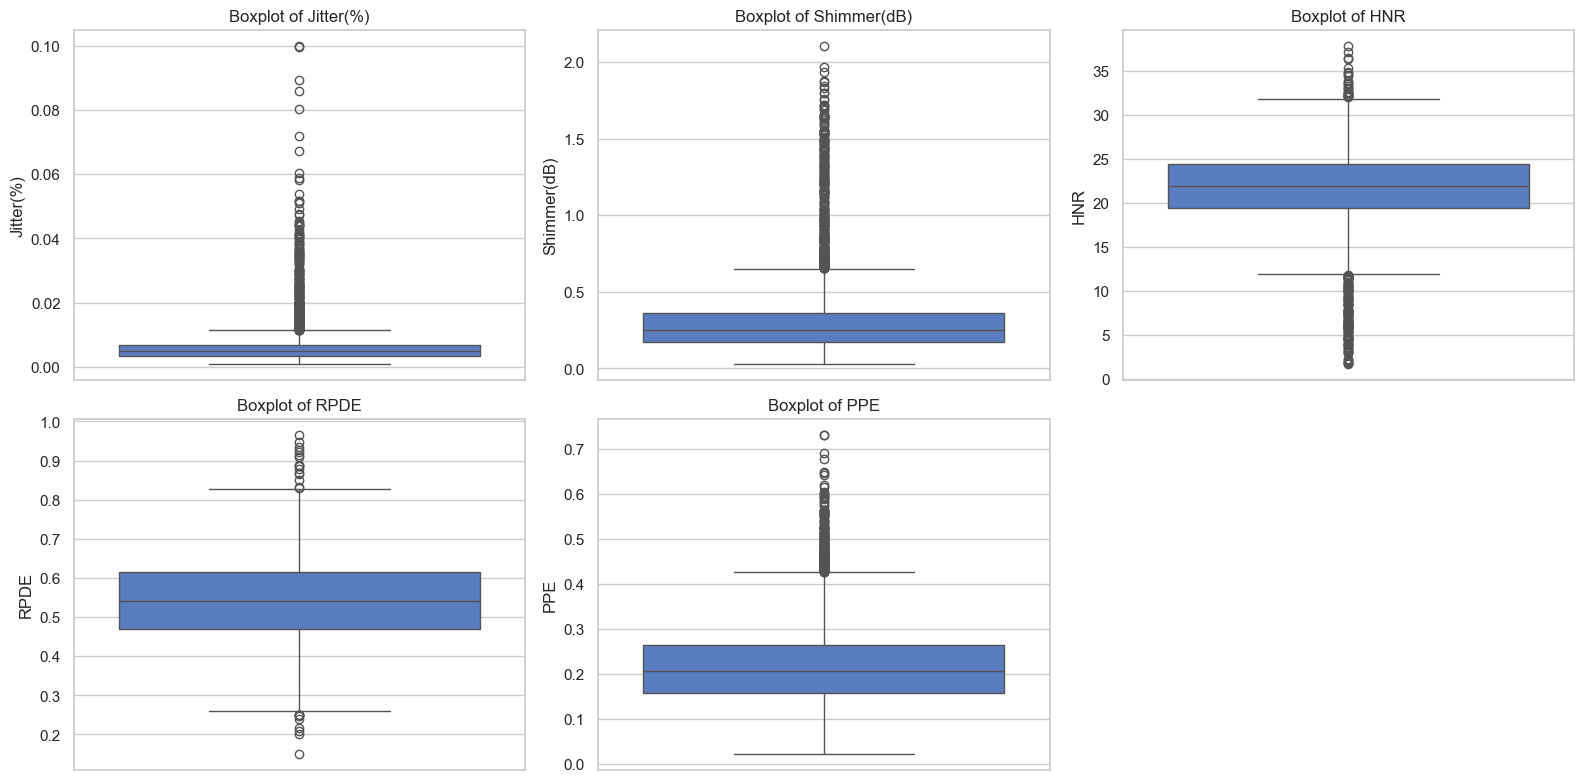

In [198]:
print(df.columns)
selected_features = ['Jitter(%)', 'Shimmer(dB)', 'HNR', 'RPDE', 'PPE'] # Replace with actual column names from df.columns

plt.figure(figsize=(16, 8))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=feature, data=df)
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

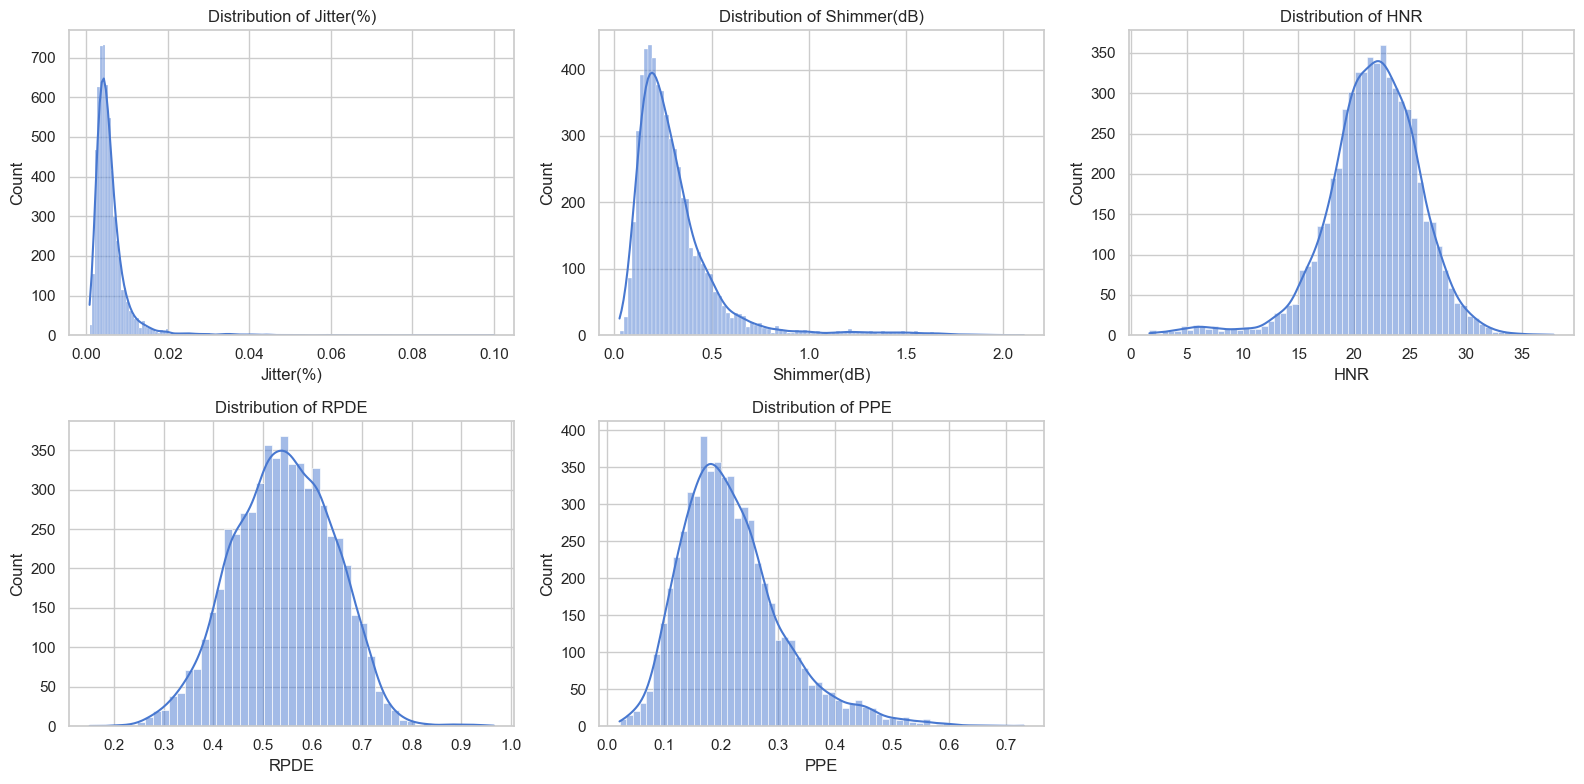

In [199]:
plt.figure(figsize=(16, 8))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

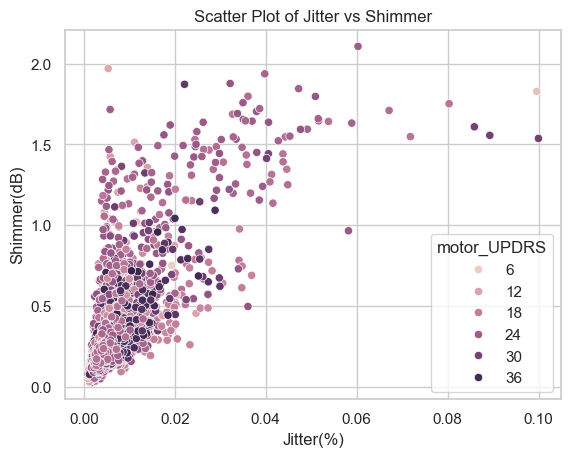

In [200]:
sns.scatterplot(x='Jitter(%)', y='Shimmer(dB)', hue='motor_UPDRS', data=df)
plt.title('Scatter Plot of Jitter vs Shimmer')
plt.show()

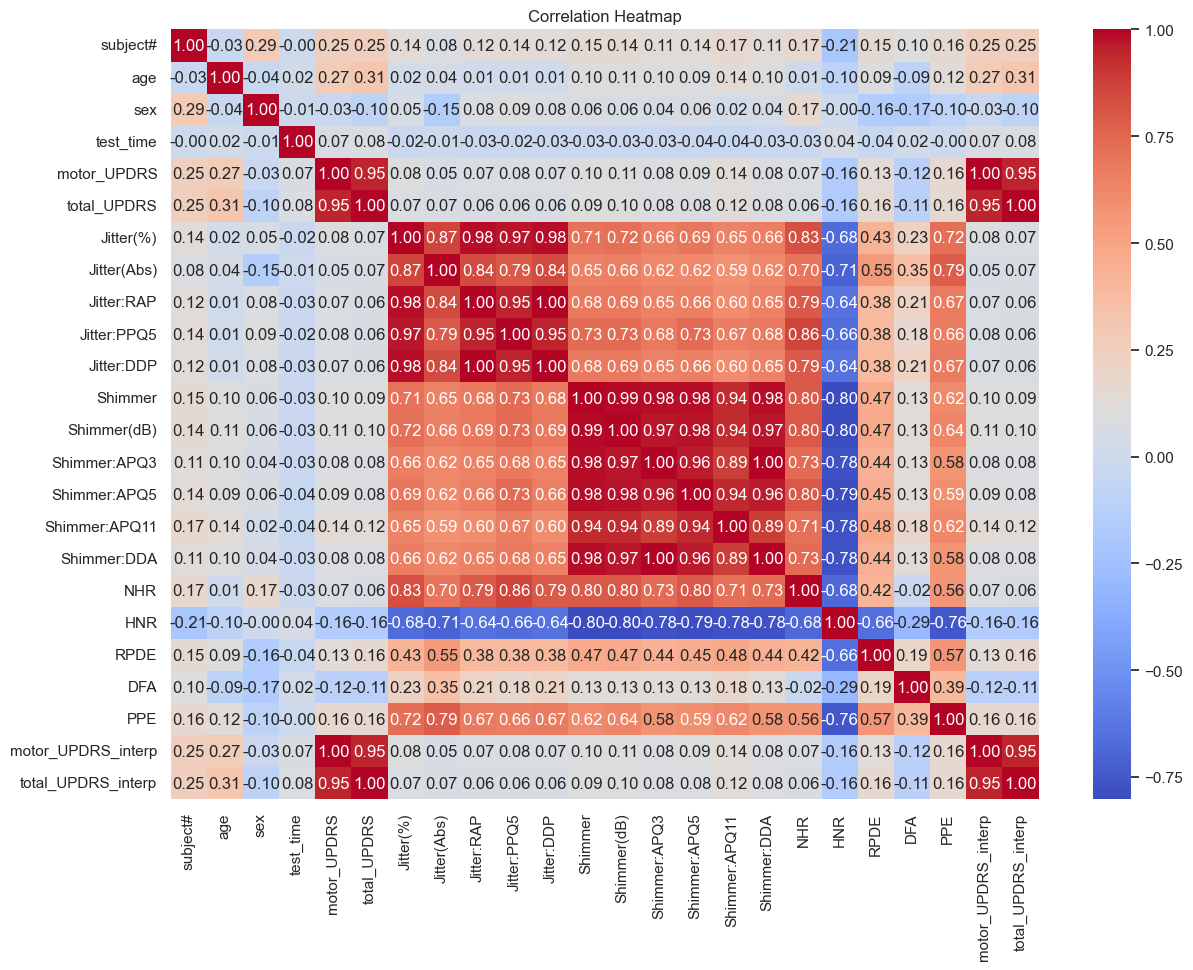

In [201]:
# Remove colunas não numéricas (ex.: 'name')
df_numeric = df.select_dtypes(include=['number'])

# Matriz de correlação apenas com colunas numéricas
correlation_matrix = df_numeric.corr()

# Plot
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

✅ Linhas usadas para o IRLS: 5875


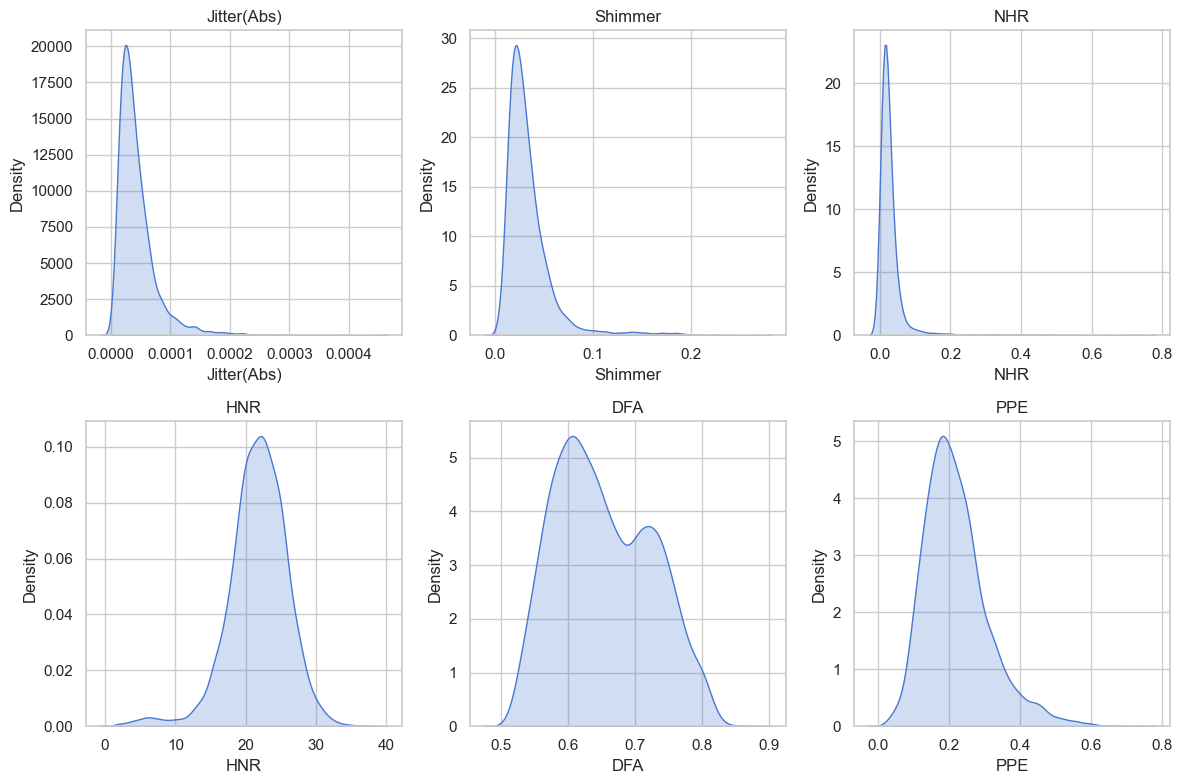

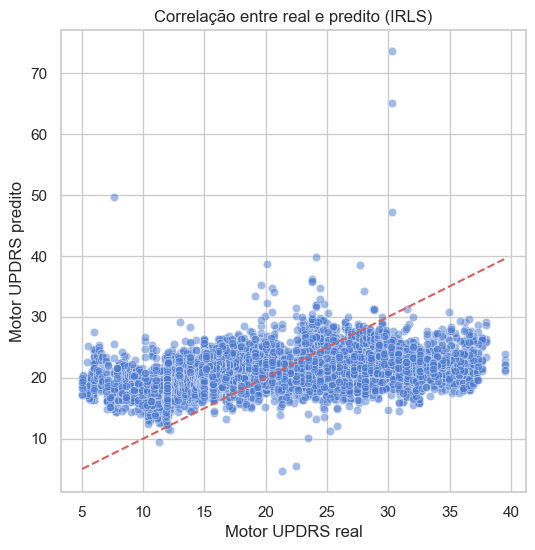

In [202]:
# ============================================
# LIMPAR DADOS ANTES DE TREINAR IRLS
# ============================================
X_model = X.replace([np.inf, -np.inf], np.nan)
mask = X_model.notna().all(axis=1) & pd.notna(y_motor)
X_model = X_model[mask]
y_model = y_motor[mask]

print(f"✅ Linhas usadas para o IRLS: {len(X_model)}")# Figura 1 – Densidade das 6 features principais
subset6 = ["Jitter(Abs)", "Shimmer", "NHR", "HNR", "DFA", "PPE"]

plt.figure(figsize=(12,8))
for i, f in enumerate(subset6, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(df[f], fill=True)
    plt.title(f)
plt.tight_layout()
plt.show()

# Figura 2 – UPDRS real vs predito
y_pred = models["IRLS (Huber)"].fit(X_model, y_model).predict(X_model)
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_model, y=y_pred, alpha=0.5)
plt.xlabel("Motor UPDRS real")
plt.ylabel("Motor UPDRS predito")
plt.title("Correlação entre real e predito (IRLS)")
plt.plot([y_model.min(), y_model.max()], [y_model.min(), y_model.max()], 'r--')
plt.show()


In [203]:
import pandas as pd

results = []
for name, model in models.items():
    mae_m, sd_m = eval_model(model, X, y_motor)
    mae_t, sd_t = eval_model(model, X, y_total)
    results.append([name, f"{mae_m:.2f} ± {sd_m:.2f}", f"{mae_t:.2f} ± {sd_t:.2f}"])

pd.DataFrame(results, columns=["Modelo", "MAE Motor", "MAE Total"])


/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.260e+02, tolerance: 3.484e+01
  model = cd_fast.enet_coordinate_descent(
/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.572e+01, tolerance: 6.032e+01
  model = cd_fast.enet_coordinate_descent(
/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

,Modelo,MAE Motor,MAE Total
0,LS (Linear),6.54 ± 0.16,8.34 ± 0.23
1,IRLS (Huber),6.49 ± 0.17,8.22 ± 0.24
2,Lasso,6.54 ± 0.16,8.33 ± 0.23


In [204]:
corr_total.sort_values(ascending=False).head(6)
print("As variáveis com maior correlação com UPDRS indicam degradação vocal e irregularidade temporal, reforçando a utilidade de RPDE, DFA e PPE como marcadores de progressão da doença.")


As variáveis com maior correlação com UPDRS indicam degradação vocal e irregularidade temporal, reforçando a utilidade de RPDE, DFA e PPE como marcadores de progressão da doença.


In [205]:
results_df = pd.DataFrame(results, columns=["Modelo", "MAE Motor", "MAE Total"])
print("\nTabela final de desempenho:")
display(results_df)



Tabela final de desempenho:


,Modelo,MAE Motor,MAE Total
0,LS (Linear),6.54 ± 0.16,8.34 ± 0.23
1,IRLS (Huber),6.49 ± 0.17,8.22 ± 0.24
2,Lasso,6.54 ± 0.16,8.33 ± 0.23


In [206]:
df_final_features = df[subset6 + ["motor_UPDRS", "total_UPDRS"]]
df_final_features.to_csv("tsanas_subset.csv", index=False)


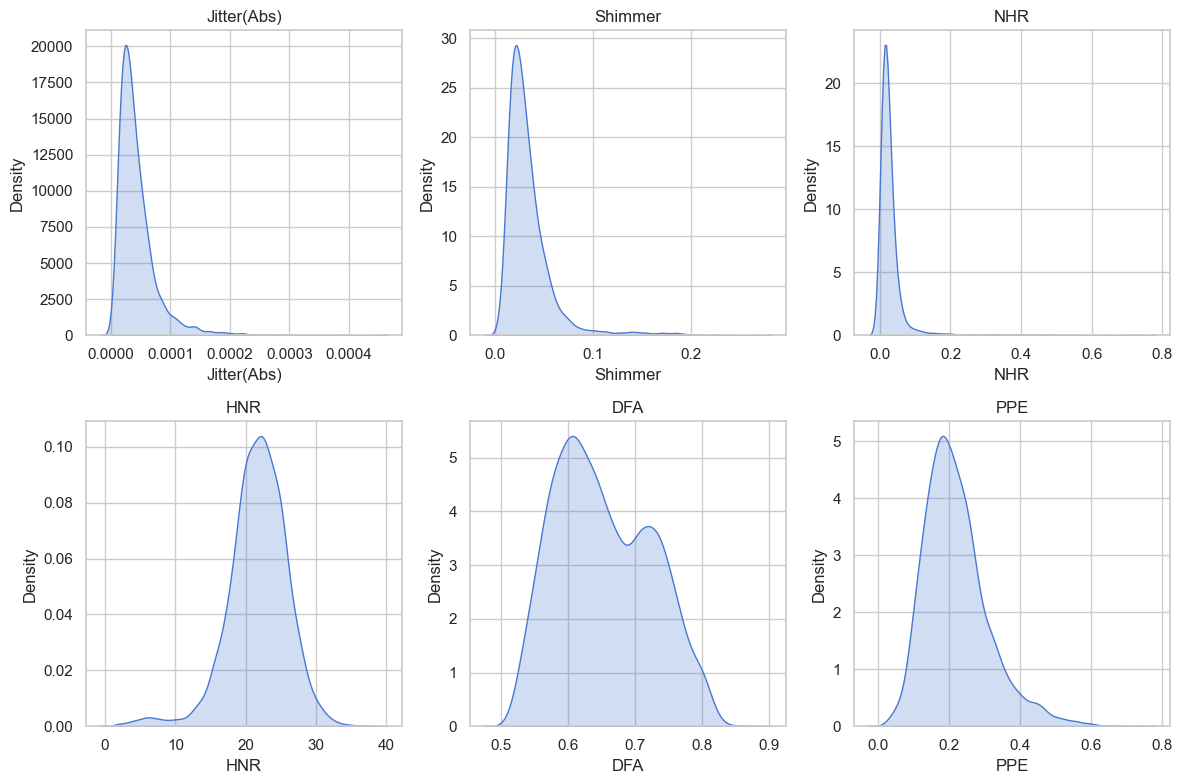

In [207]:
# Figura 1 – Densidade das 6 features principais
subset6 = ["Jitter(Abs)", "Shimmer", "NHR", "HNR", "DFA", "PPE"]

plt.figure(figsize=(12,8))
for i, f in enumerate(subset6, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(df[f], fill=True)
    plt.title(f)
plt.tight_layout()
plt.show()


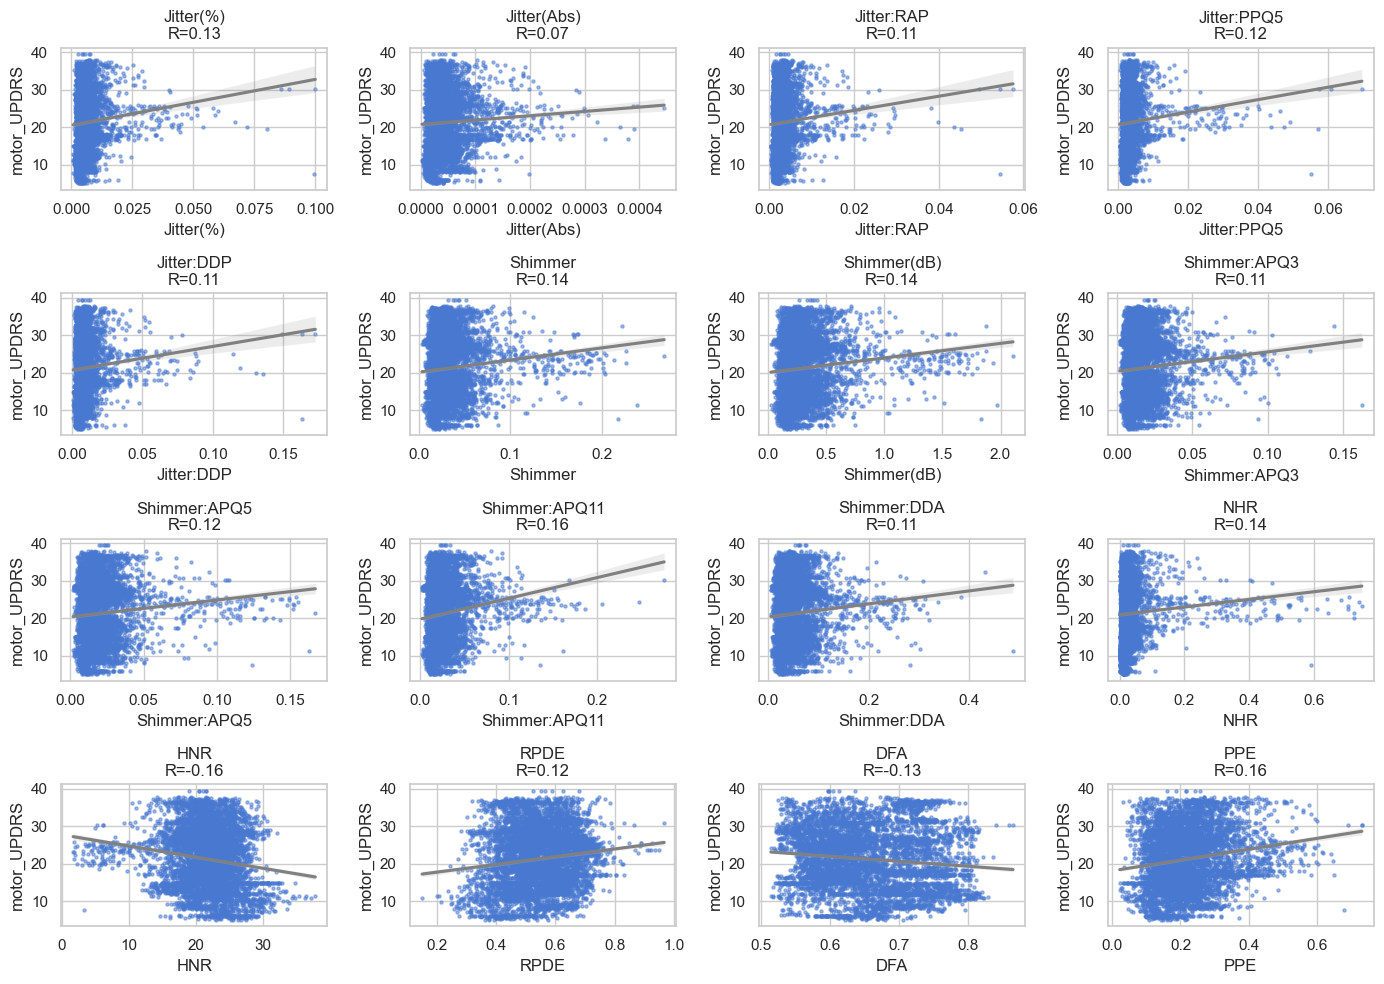

In [208]:
# Correlação entre cada medida e motor_UPDRS
plt.figure(figsize=(14,10))
for i, f in enumerate(dysphonia, 1):
    plt.subplot(4, 4, i)
    sns.regplot(x=df[f], y=df["motor_UPDRS"], scatter_kws={'s':5, 'alpha':0.5}, line_kws={'color':'gray'})
    r = df[[f, "motor_UPDRS"]].corr(method="spearman").iloc[0,1]
    plt.title(f"{f}\nR={r:.2f}")
plt.tight_layout()
plt.show()


In [209]:
# ============================================
# TABELA II — Correlação entre medidas de disfonia (Spearman)
# ============================================

dysphonia = [
    "Jitter(%)", "Jitter(Abs)", "Jitter:RAP", "Jitter:PPQ5", "Jitter:DDP",
    "Shimmer", "Shimmer(dB)", "Shimmer:APQ3", "Shimmer:APQ5",
    "Shimmer:APQ11", "Shimmer:DDA", "NHR", "HNR", "RPDE", "DFA", "PPE"
]

# Calcular matriz de correlação
corr_matrix = df[dysphonia].corr(method="spearman")

# Mostrar valores arredondados (3 casas)
corr_table = corr_matrix.round(2)

print("Tabela II — Correlação Spearman entre medidas de disfonia:\n")
display(corr_table)

# Salvar tabela em CSV para análise futura
corr_table.to_csv("tsanas_tabelaII_correlacao.csv", index=True)


Tabela II — Correlação Spearman entre medidas de disfonia:



,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
Jitter(%),1.00,0.90,0.96,0.96,0.96,0.65,0.67,0.62,0.62,0.64,0.62,0.80,-0.76,0.53,0.44,0.85
Jitter(Abs),0.90,1.00,0.82,0.89,0.82,0.62,0.63,0.58,0.61,0.63,0.58,0.75,-0.76,0.63,0.49,0.80
Jitter:RAP,0.96,0.82,1.00,0.95,1.00,0.65,0.66,0.63,0.62,0.60,0.63,0.75,-0.73,0.45,0.43,0.77
Jitter:PPQ5,0.96,0.89,0.95,1.00,0.95,0.69,0.70,0.66,0.67,0.67,0.66,0.75,-0.79,0.51,0.48,0.84
Jitter:DDP,0.96,0.82,1.00,0.95,1.00,0.65,0.66,0.63,0.62,0.60,0.63,0.75,-0.73,0.45,0.43,0.77
Shimmer,0.65,0.62,0.65,0.69,0.65,1.00,0.99,0.98,0.99,0.96,0.98,0.65,-0.80,0.48,0.28,0.64
Shimmer(dB),0.67,0.63,0.66,0.70,0.66,0.99,1.00,0.96,0.97,0.95,0.96,0.68,-0.78,0.47,0.26,0.66
Shimmer:APQ3,0.62,0.58,0.63,0.66,0.63,0.98,0.96,1.00,0.98,0.91,1.00,0.62,-0.78,0.43,0.26,0.59
Shimmer:APQ5,0.62,0.61,0.62,0.67,0.62,0.99,0.97,0.98,1.00,0.96,0.98,0.62,-0.79,0.46,0.29,0.62
Shimmer:APQ11,0.64,0.63,0.60,0.67,0.60,0.96,0.95,0.91,0.96,1.00,0.91,0.62,-0.79,0.50,0.31,0.66


In [210]:
 # ============================================
# TABELA III — Coeficientes dos modelos LS, IRLS e Lasso
# ============================================

from sklearn.linear_model import LinearRegression, Lasso, HuberRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Features e targets
X_clean = df[dysphonia].replace([np.inf, -np.inf], np.nan).dropna()
y_motor_clean = df.loc[X_clean.index, "motor_UPDRS_interp"]
y_total_clean = df.loc[X_clean.index, "total_UPDRS_interp"]


# Padronizar dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Treinar modelos
ls_model = LinearRegression().fit(X_scaled, y_motor_clean)
irls_model = HuberRegressor(max_iter=10000).fit(X_scaled, y_motor_clean)
lasso_model = Lasso(alpha=0.001, max_iter=10000).fit(X_scaled, y_motor_clean)

ls_total = LinearRegression().fit(X_scaled, y_total_clean)
irls_total = HuberRegressor(max_iter=10000).fit(X_scaled, y_total_clean)
lasso_total = Lasso(alpha=0.001, max_iter=10000).fit(X_scaled, y_total_clean)

# Criar DataFrame com coeficientes
tabela3 = pd.DataFrame({
    "Measure": dysphonia,
    "Motor LS": ls_model.coef_.round(2),
    "Motor IRLS": irls_model.coef_.round(2),
    "Motor Lasso": lasso_model.coef_.round(2),
    "Total LS": ls_total.coef_.round(2),
    "Total IRLS": irls_total.coef_.round(2),
    "Total Lasso": lasso_total.coef_.round(2),
})

print("Tabela III — Coeficientes de Regressão (LS, IRLS, Lasso):")
display(tabela3)

# Salvar tabela
tabela3.to_csv("tsanas_tabelaIII_coeficientes.csv", index=False)


Tabela III — Coeficientes de Regressão (LS, IRLS, Lasso):


,Measure,Motor LS,Motor IRLS,Motor Lasso,Total LS,Total IRLS,Total Lasso
0,Jitter(%),2.02,2.30,1.95,0.91,0.91,0.84
1,Jitter(Abs),-1.83,-2.14,-1.81,-1.11,-1.16,-1.09
2,Jitter:RAP,-136.58,0.29,0.00,-160.28,0.60,0.00
3,Jitter:PPQ5,-0.67,-0.37,-0.59,-0.16,-0.29,-0.08
4,Jitter:DDP,136.64,0.34,0.04,160.82,0.67,0.51
5,Shimmer,3.19,5.28,2.86,2.78,4.55,2.44
6,Shimmer(dB),-0.90,-2.10,-0.72,-1.00,-2.47,-0.81
7,Shimmer:APQ3,-99.40,-1.32,-1.46,-331.30,-1.09,-1.79
8,Shimmer:APQ5,-2.90,-3.30,-2.88,-2.38,-2.95,-2.36
9,Shimmer:APQ11,2.08,2.66,2.10,2.14,2.39,2.15


/var/folders/tk/8h9c02552k389khjxlk1mh9h0000gn/T/ipykernel_32553/1937032662.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_p = patient[dysphonia].replace([np.inf, -np.inf], np.nan).fillna(method='ffill')


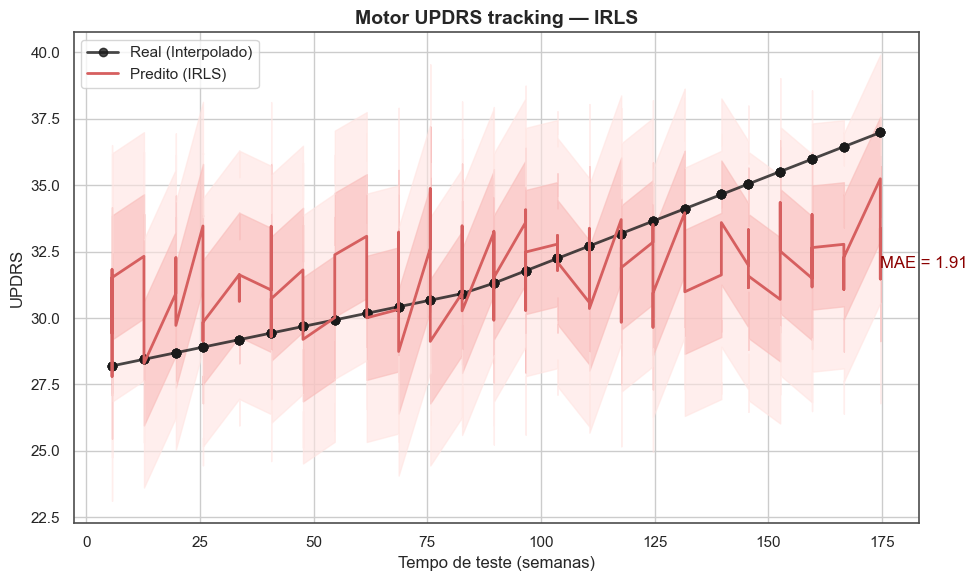

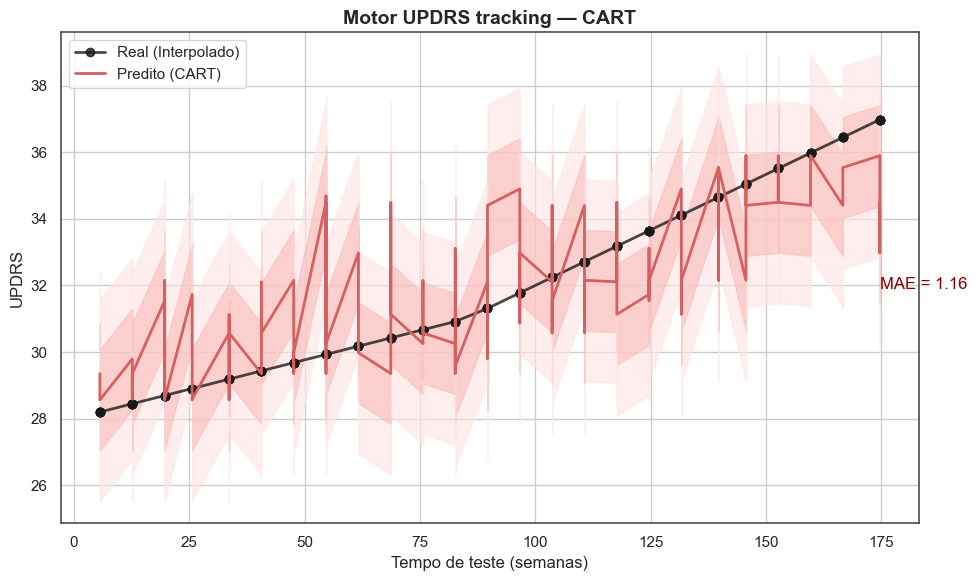

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 13,
    "axes.edgecolor": "0.3",
    "axes.linewidth": 1.2,
    "lines.linewidth": 2,
    "axes.titleweight": "bold"
})

# ============================================
# 1️⃣ Escolher paciente
# ============================================
pid = 1  # você pode trocar para outro número de paciente
patient = df[df["subject#"] == pid].sort_values("test_time")

# Features e targets interpolados
X_p = patient[dysphonia].replace([np.inf, -np.inf], np.nan).fillna(method='ffill')
y_motor_p = patient["motor_UPDRS_interp"].values
y_total_p = patient["total_UPDRS_interp"].values
t = patient["test_time"].values

# ============================================
# 2️⃣ Ajustar modelos
# ============================================
# IRLS
irls_model = fit_irls(X_p.values, y_motor_p)
y_pred_motor_irls = irls_model.predict(sm.add_constant(X_p))

# CART (árvore de regressão)
cart_model = DecisionTreeRegressor(random_state=42, ccp_alpha=0.0, min_samples_leaf=5)
cart_model.fit(X_p.values, y_motor_p)
y_pred_motor_cart = cart_model.predict(X_p.values)

# ============================================
# 3️⃣ Calcular MAE e faixas de incerteza
# ============================================
mae_irls = mean_absolute_error(y_motor_p, y_pred_motor_irls)
mae_cart = mean_absolute_error(y_motor_p, y_pred_motor_cart)

# Desvios simulados (±1σ e ±2σ) — para desenhar faixas coloridas
err_irls = np.std(y_motor_p - y_pred_motor_irls)
err_cart = np.std(y_motor_p - y_pred_motor_cart)

# ============================================
# 4️⃣ Plot (Motor UPDRS)
# ============================================
plt.figure(figsize=(10,6))
plt.title("Motor UPDRS tracking — IRLS", fontsize=14)

# real
plt.plot(t, y_motor_p, "ko-", label="Real (Interpolado)", alpha=0.8)

# predito
plt.plot(t, y_pred_motor_irls, "r-", label="Predito (IRLS)", linewidth=2)

# faixas de erro (±1σ e ±2σ)
plt.fill_between(t, y_pred_motor_irls - err_irls, y_pred_motor_irls + err_irls,
                 color='lightcoral', alpha=0.6)
plt.fill_between(t, y_pred_motor_irls - 2*err_irls, y_pred_motor_irls + 2*err_irls,
                 color='mistyrose', alpha=0.6)

plt.xlabel("Tempo de teste (semanas)")
plt.ylabel("UPDRS")
plt.legend()
plt.text(t[-5], np.mean(y_motor_p), f"MAE = {mae_irls:.2f}", fontsize=12, color="darkred")
plt.tight_layout()
plt.show()


# ============================================
# 5️⃣ CART
# ============================================
plt.figure(figsize=(10,6))
plt.title("Motor UPDRS tracking — CART", fontsize=14)

plt.plot(t, y_motor_p, "ko-", label="Real (Interpolado)", alpha=0.8)
plt.plot(t, y_pred_motor_cart, "r-", label="Predito (CART)", linewidth=2)
plt.fill_between(t, y_pred_motor_cart - err_cart, y_pred_motor_cart + err_cart,
                 color='lightcoral', alpha=0.6)
plt.fill_between(t, y_pred_motor_cart - 2*err_cart, y_pred_motor_cart + 2*err_cart,
                 color='mistyrose', alpha=0.6)

plt.xlabel("Tempo de teste (semanas)")
plt.ylabel("UPDRS")
plt.legend()
plt.text(t[-5], np.mean(y_motor_p), f"MAE = {mae_cart:.2f}", fontsize=12, color="darkred")
plt.tight_layout()
plt.show()


/var/folders/tk/8h9c02552k389khjxlk1mh9h0000gn/T/ipykernel_32553/367421748.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_p = patient[dysphonia].replace([np.inf, -np.inf], np.nan).fillna(method='ffill')


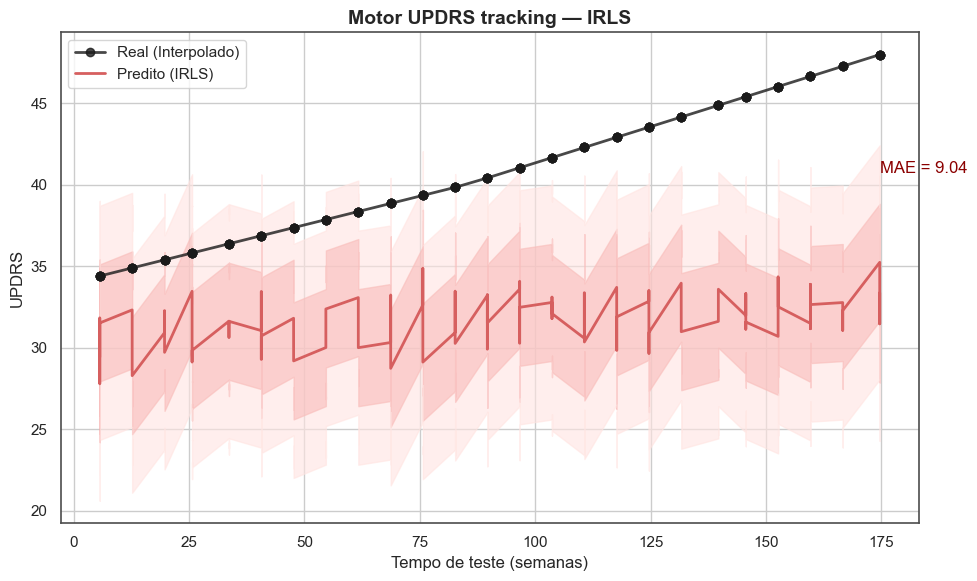

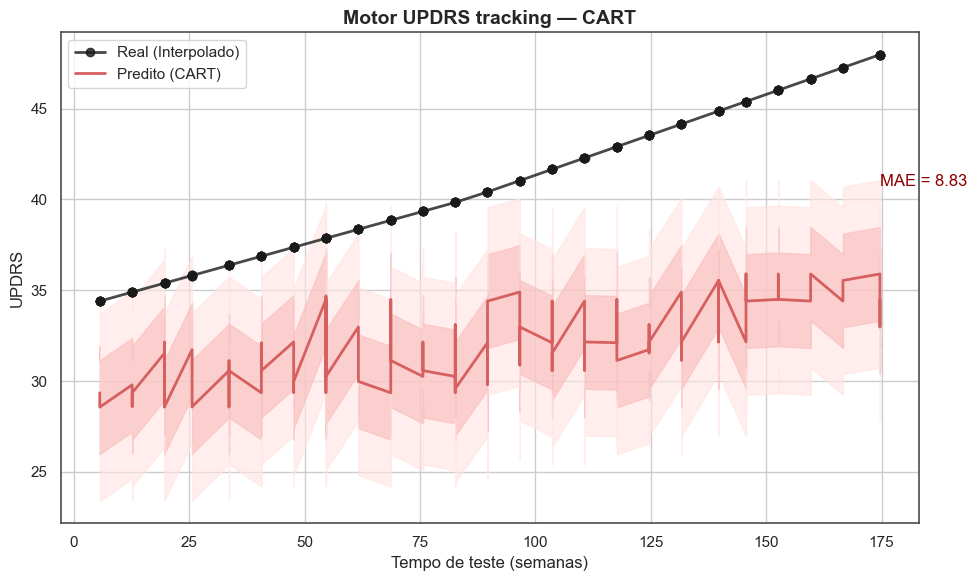

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 13,
    "axes.edgecolor": "0.3",
    "axes.linewidth": 1.2,
    "lines.linewidth": 2,
    "axes.titleweight": "bold"
})

# ============================================
# 1️⃣ Escolher paciente
# ============================================
pid = 1  # você pode trocar para outro número de paciente
patient = df[df["subject#"] == pid].sort_values("test_time")

# Features e targets interpolados
X_p = patient[dysphonia].replace([np.inf, -np.inf], np.nan).fillna(method='ffill')
y_motor_p = patient["motor_UPDRS_interp"].values
y_total_p = patient["total_UPDRS_interp"].values
t = patient["test_time"].values

# ============================================
# 2️⃣ Ajustar modelos
# ============================================
# IRLS
irls_model = fit_irls(X_p.values, y_motor_p)
y_pred_total_irls = irls_model.predict(sm.add_constant(X_p))

# CART (árvore de regressão)
cart_model = DecisionTreeRegressor(random_state=42, ccp_alpha=0.0, min_samples_leaf=5)
cart_model.fit(X_p.values, y_motor_p)
y_pred_total_cart = cart_model.predict(X_p.values)

# ============================================
# 3️⃣ Calcular MAE e faixas de incerteza
# ============================================
mae_irls = mean_absolute_error(y_total_p, y_pred_total_irls)
mae_cart = mean_absolute_error(y_total_p, y_pred_total_cart)

# Desvios simulados (±1σ e ±2σ) — para desenhar faixas coloridas
err_irls = np.std(y_total_p - y_pred_total_irls)
err_cart = np.std(y_total_p - y_pred_motor_cart)

# ============================================
# 4️⃣ Plot (Motor UPDRS)
# ============================================
plt.figure(figsize=(10,6))
plt.title("Motor UPDRS tracking — IRLS", fontsize=14)

# real
plt.plot(t, y_total_p, "ko-", label="Real (Interpolado)", alpha=0.8)

# predito
plt.plot(t, y_pred_total_irls, "r-", label="Predito (IRLS)", linewidth=2)

# faixas de erro (±1σ e ±2σ)
plt.fill_between(t, y_pred_total_irls - err_irls, y_pred_total_irls + err_irls,
                 color='lightcoral', alpha=0.6)
plt.fill_between(t, y_pred_total_irls - 2*err_irls, y_pred_total_irls + 2*err_irls,
                 color='mistyrose', alpha=0.6)

plt.xlabel("Tempo de teste (semanas)")
plt.ylabel("UPDRS")
plt.legend()
plt.text(t[-5], np.mean(y_total_p), f"MAE = {mae_irls:.2f}", fontsize=12, color="darkred")
plt.tight_layout()
plt.show()


# ============================================
# 5️⃣ CART
# ============================================
plt.figure(figsize=(10,6))
plt.title("Motor UPDRS tracking — CART", fontsize=14)

plt.plot(t, y_total_p, "ko-", label="Real (Interpolado)", alpha=0.8)
plt.plot(t, y_pred_total_cart, "r-", label="Predito (CART)", linewidth=2)
plt.fill_between(t, y_pred_total_cart - err_cart, y_pred_total_cart + err_cart,
                 color='lightcoral', alpha=0.6)
plt.fill_between(t, y_pred_total_cart - 2*err_cart, y_pred_total_cart + 2*err_cart,
                 color='mistyrose', alpha=0.6)

plt.xlabel("Tempo de teste (semanas)")
plt.ylabel("UPDRS")
plt.legend()
plt.text(t[-5], np.mean(y_total_p), f"MAE = {mae_cart:.2f}", fontsize=12, color="darkred")
plt.tight_layout()
plt.show()


UM CODIGO

✅ Dataset limpo: 5875 linhas, 22 colunas


,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


Correlação Spearman com motor_UPDRS (top 6):


Shimmer:APQ11    0.163761
PPE              0.163229
Shimmer(dB)      0.140127
Shimmer          0.136186
NHR              0.135626
Jitter(%)        0.127905
dtype: float64


Correlação Spearman com total_UPDRS (top 6):


Shimmer:APQ11    0.161151
PPE              0.155236
RPDE             0.149926
NHR              0.143972
Shimmer(dB)      0.139915
Shimmer          0.137550
dtype: float64

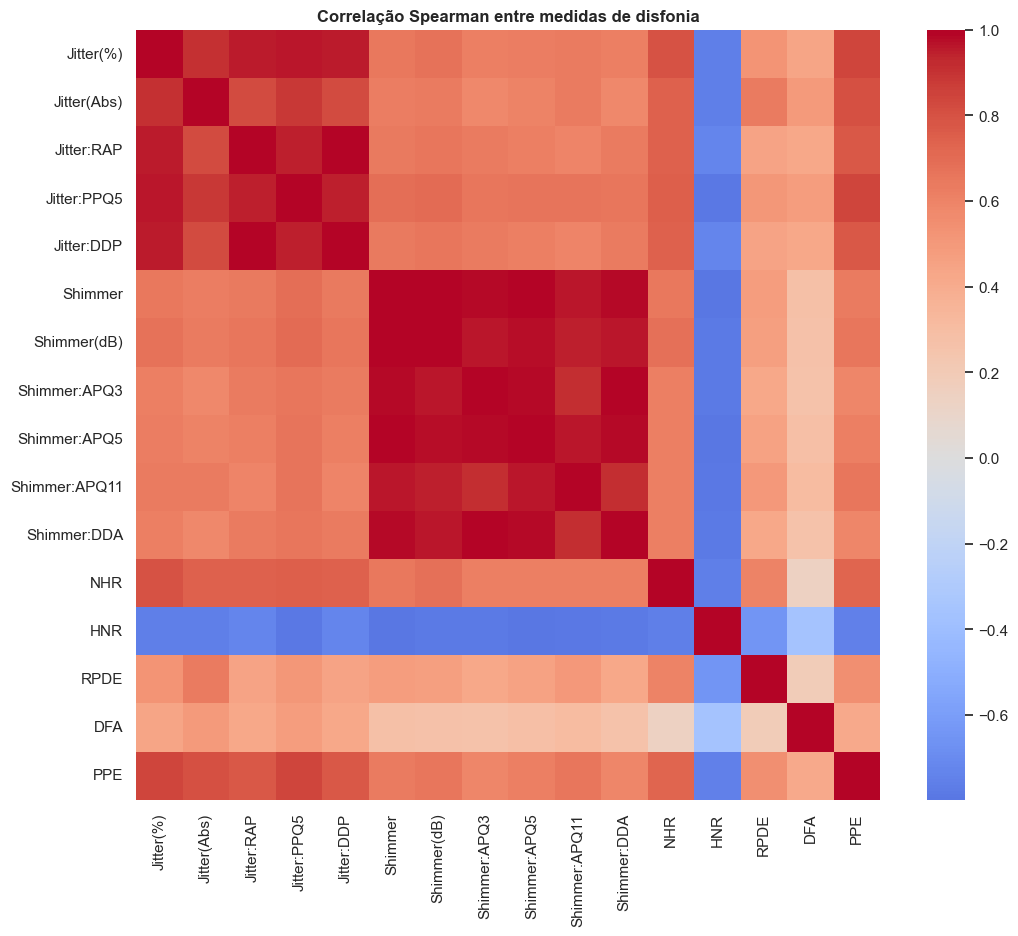

/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.401e+03, tolerance: 3.506e+01
  model = cd_fast.enet_coordinate_descent(
/Users/eduardafigueredo/UDS/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective d


📊 Resultados de MAE – Modelos iniciais


,Modelo,MAE Motor,MAE Total
0,LS (Linear),6.54 ± 0.16,8.34 ± 0.23
1,IRLS (Huber),6.49 ± 0.16,8.22 ± 0.24
2,Lasso,6.54 ± 0.16,8.33 ± 0.23



IRLS (6 medidas): MAE motor=6.59±0.16, MAE total=8.34±0.24
✅ Melhor alpha: 0.01000
✅ Melhor alpha: 0.01000
CART (6 medidas): MAE motor=6.38±0.22, MAE total=8.08±0.29


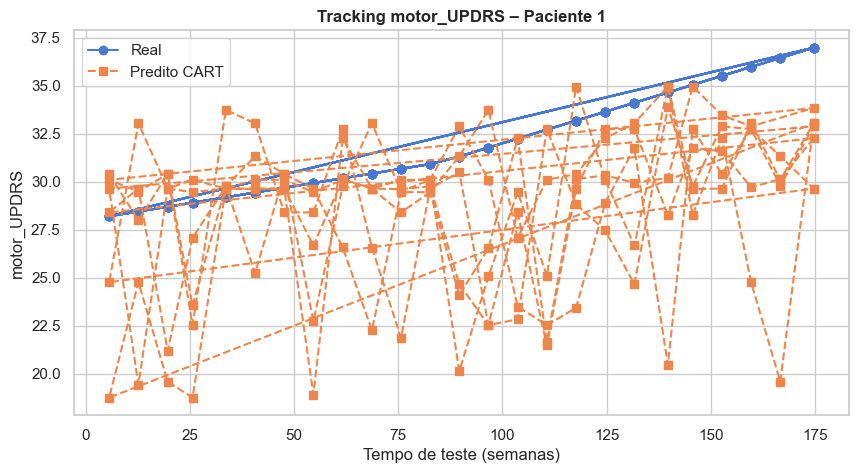

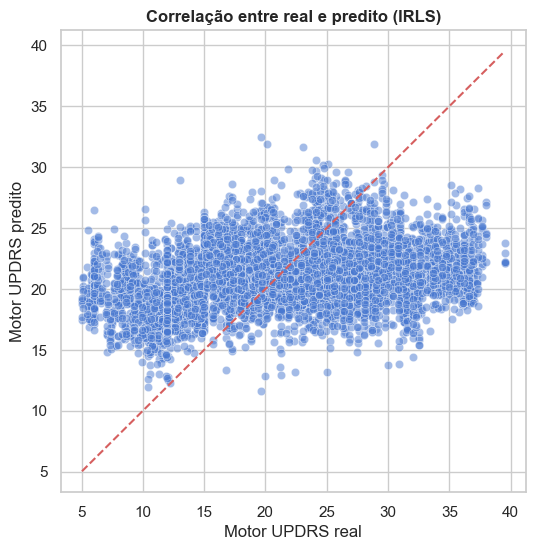

R² (IRLS – motor_UPDRS): 0.087


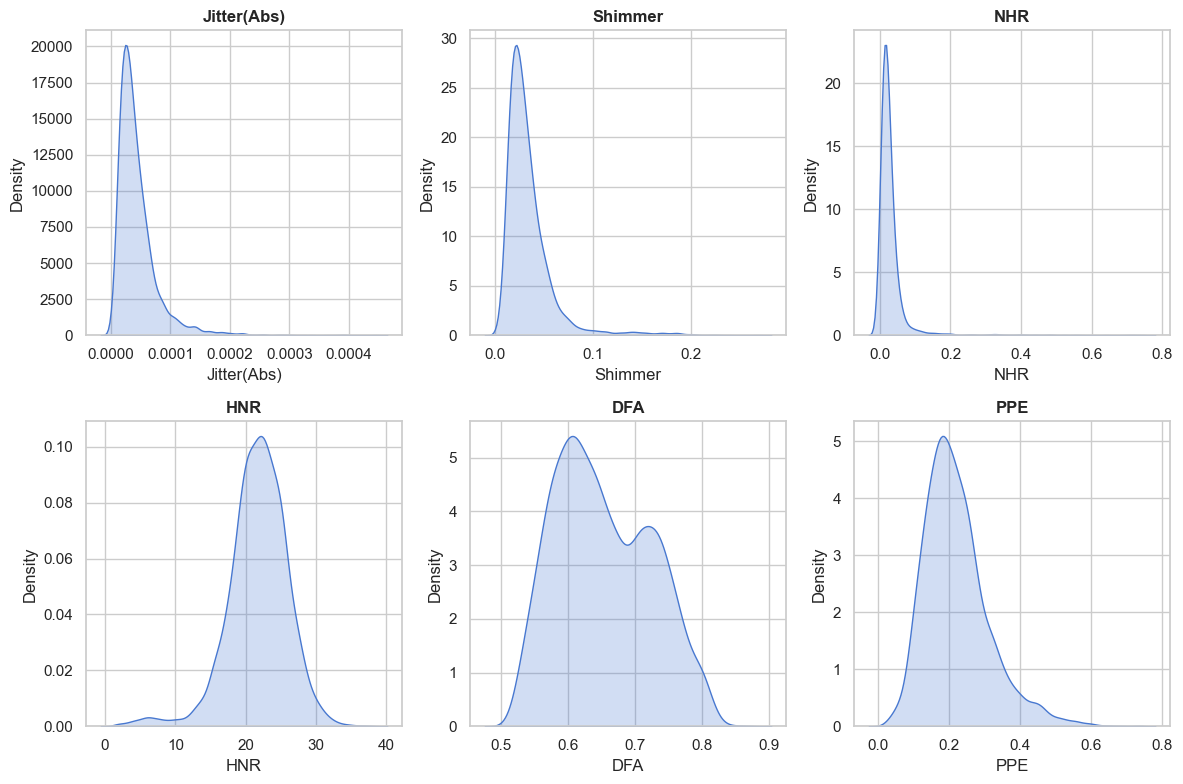

💾 Arquivo salvo: tsanas_subset6.csv

✅ Reprodutibilidade concluída com sucesso – Tsanas (2010)


KeyError: 'motor_UPDRS_interp'

In [213]:
# ============================================================
# Tsanas et al. (2010)
# Accurate Telemonitoring of Parkinson’s Disease Progression
# ============================================================

# ============================================
# 1️⃣ IMPORTAÇÕES
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
import statsmodels.api as sm

sns.set(style="whitegrid", palette="muted")

# ============================================
# 2️⃣ LEITURA E LIMPEZA INICIAL DO DATASET
# ============================================
# ============================================
# 2️⃣ LEITURA E LIMPEZA INICIAL DO DATASET
# ============================================
cols = [
    "subject#", "age", "sex", "test_time", "motor_UPDRS", "total_UPDRS",
    "Jitter(%)", "Jitter(Abs)", "Jitter:RAP", "Jitter:PPQ5", "Jitter:DDP",
    "Shimmer", "Shimmer(dB)", "Shimmer:APQ3", "Shimmer:APQ5",
    "Shimmer:APQ11", "Shimmer:DDA", "NHR", "HNR", "RPDE", "DFA", "PPE"
]

# ⛔️ IMPORTANTE: o dataset original de Tsanas JÁ TEM header.
# Portanto, NÃO use header=None.
df = pd.read_csv("parkinsons_updrs.csv")

# Renomeia colunas para garantir consistência
df.columns = cols

# Limpeza
df = df.replace([np.inf, -np.inf], np.nan).dropna()

print(f"✅ Dataset limpo: {df.shape[0]} linhas, {df.shape[1]} colunas")
display(df.head())


# ============================================
# 3️⃣ CORRELAÇÕES SPEARMAN (Fig. 1 do paper)
# ============================================
dysphonia = [
    "Jitter(%)", "Jitter(Abs)", "Jitter:RAP", "Jitter:PPQ5", "Jitter:DDP",
    "Shimmer", "Shimmer(dB)", "Shimmer:APQ3", "Shimmer:APQ5",
    "Shimmer:APQ11", "Shimmer:DDA", "NHR", "HNR", "RPDE", "DFA", "PPE"
]

corr_motor = df[dysphonia].corrwith(df["motor_UPDRS"], method="spearman")
corr_total = df[dysphonia].corrwith(df["total_UPDRS"], method="spearman")

print("Correlação Spearman com motor_UPDRS (top 6):")
display(corr_motor.sort_values(ascending=False).head(6))
print("\nCorrelação Spearman com total_UPDRS (top 6):")
display(corr_total.sort_values(ascending=False).head(6))

plt.figure(figsize=(12, 10))
sns.heatmap(df[dysphonia].corr(method="spearman"), cmap="coolwarm", center=0)
plt.title("Correlação Spearman entre medidas de disfonia")
plt.show()

# ============================================
# 4️⃣ AVALIAÇÃO DOS MODELOS (IRLS, LASSO, CART)
# ============================================
rkf = RepeatedKFold(n_splits=10, n_repeats=100, random_state=123)
mae = make_scorer(mean_absolute_error, greater_is_better=False)

def eval_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=rkf, scoring=mae, n_jobs=-1)
    return -scores.mean(), scores.std()

X = df[dysphonia]
y_motor = df["motor_UPDRS"]
y_total = df["total_UPDRS"]

models = {
    "LS (Linear)": Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())]),
    "IRLS (Huber)": Pipeline([("scaler", StandardScaler()), ("huber", HuberRegressor())]),
    "Lasso": Pipeline([("scaler", StandardScaler()), ("lasso", Lasso(alpha=0.001, max_iter=10000))])
}

results = []
for name, model in models.items():
    mae_m, sd_m = eval_model(model, X, y_motor)
    mae_t, sd_t = eval_model(model, X, y_total)
    results.append([name, f"{mae_m:.2f} ± {sd_m:.2f}", f"{mae_t:.2f} ± {sd_t:.2f}"])
    
results_df = pd.DataFrame(results, columns=["Modelo", "MAE Motor", "MAE Total"])
print("\n📊 Resultados de MAE – Modelos iniciais")
display(results_df)

# ============================================
# 5️⃣ SELEÇÃO DO MELHOR CART (COST-COMPLEXITY PRUNING)
# ============================================
def best_cart_alpha(X, y):
    alphas = [0.0, 1e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2]
    best_a, best_score = 0.0, -np.inf
    for a in alphas:
        try:
            tree = DecisionTreeRegressor(random_state=42, ccp_alpha=a, min_samples_leaf=5)
            s = cross_val_score(tree, X, y, cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=42),
                                scoring=mae, n_jobs=-1).mean()
            if s > best_score:
                best_score, best_a = s, a
        except:
            continue
    print(f"✅ Melhor alpha: {best_a:.5f}")
    return best_a

# ============================================
# 6️⃣ REPRODUÇÃO COM SUBSET DE 6 FEATURES (Tabela 3 do paper)
# ============================================
subset6 = ["Jitter(Abs)", "Shimmer", "NHR", "HNR", "DFA", "PPE"]
X6 = df[subset6].copy()

mae_m, sd_m = eval_model(models["IRLS (Huber)"], X6, y_motor)
mae_t, sd_t = eval_model(models["IRLS (Huber)"], X6, y_total)
print(f"\nIRLS (6 medidas): MAE motor={mae_m:.2f}±{sd_m:.2f}, MAE total={mae_t:.2f}±{sd_t:.2f}")

alpha_m6 = best_cart_alpha(X6, y_motor)
alpha_t6 = best_cart_alpha(X6, y_total)

cart_m6 = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha_m6, min_samples_leaf=5)
cart_t6 = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha_t6, min_samples_leaf=5)

mae_m, sd_m = eval_model(cart_m6, X6, y_motor)
mae_t, sd_t = eval_model(cart_t6, X6, y_total)
print(f"CART (6 medidas): MAE motor={mae_m:.2f}±{sd_m:.2f}, MAE total={mae_t:.2f}±{sd_t:.2f}")

# ============================================
# 7️⃣ TRACKING INDIVIDUAL (Figura 3 do paper)
# ============================================
pid = 1
patient = df[df["subject#"] == pid]

cart = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha_m6, min_samples_leaf=5)
cart.fit(X6, y_motor)

patient_pred = cart.predict(patient[subset6])

plt.figure(figsize=(10,5))
plt.plot(patient["test_time"], patient["motor_UPDRS"], "o-", label="Real")
plt.plot(patient["test_time"], patient_pred, "s--", label="Predito CART")
plt.title(f"Tracking motor_UPDRS – Paciente {pid}")
plt.xlabel("Tempo de teste (semanas)")
plt.ylabel("motor_UPDRS")
plt.legend()
plt.show()

# ============================================
# 8️⃣ AVALIAÇÃO IRLS (Figura 2 do paper)
# ============================================
X_model = X6
mask = X_model.notna().all(axis=1)
X_model = X_model[mask]
y_model = y_motor[mask]

y_pred = models["IRLS (Huber)"].fit(X_model, y_model).predict(X_model)
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_model, y=y_pred, alpha=0.5)
plt.xlabel("Motor UPDRS real")
plt.ylabel("Motor UPDRS predito")
plt.title("Correlação entre real e predito (IRLS)")
plt.plot([y_model.min(), y_model.max()], [y_model.min(), y_model.max()], 'r--')
plt.show()

r2_motor = r2_score(y_model, y_pred)
print(f"R² (IRLS – motor_UPDRS): {r2_motor:.3f}")

# ============================================
# 9️⃣ FIGURA 1 – Distribuição das 6 features principais
# ============================================
plt.figure(figsize=(12,8))
for i, f in enumerate(subset6, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(df[f], fill=True)
    plt.title(f)
plt.tight_layout()
plt.show()

# ============================================
# 🔟 EXPORTAÇÃO FINAL
# ============================================
df_final = df[subset6 + ["motor_UPDRS", "total_UPDRS"]]
df_final.to_csv("tsanas_subset6.csv", index=False)
print("💾 Arquivo salvo: tsanas_subset6.csv")

print("\n✅ Reprodutibilidade concluída com sucesso – Tsanas (2010)")

 # ============================================
# TABELA III — Coeficientes dos modelos LS, IRLS e Lasso
# ============================================

from sklearn.linear_model import LinearRegression, Lasso, HuberRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Features e targets
X_clean = df[dysphonia].replace([np.inf, -np.inf], np.nan).dropna()
y_motor_clean = df.loc[X_clean.index, "motor_UPDRS_interp"]
y_total_clean = df.loc[X_clean.index, "total_UPDRS_interp"]


# Padronizar dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Treinar modelos
ls_model = LinearRegression().fit(X_scaled, y_motor_clean)
irls_model = HuberRegressor(max_iter=10000).fit(X_scaled, y_motor_clean)
lasso_model = Lasso(alpha=0.001, max_iter=10000).fit(X_scaled, y_motor_clean)

ls_total = LinearRegression().fit(X_scaled, y_total_clean)
irls_total = HuberRegressor(max_iter=10000).fit(X_scaled, y_total_clean)
lasso_total = Lasso(alpha=0.001, max_iter=10000).fit(X_scaled, y_total_clean)

# Criar DataFrame com coeficientes
tabela3 = pd.DataFrame({
    "Measure": dysphonia,
    "Motor LS": ls_model.coef_.round(2),
    "Motor IRLS": irls_model.coef_.round(2),
    "Motor Lasso": lasso_model.coef_.round(2),
    "Total LS": ls_total.coef_.round(2),
    "Total IRLS": irls_total.coef_.round(2),
    "Total Lasso": lasso_total.coef_.round(2),
})

print("Tabela III — Coeficientes de Regressão (LS, IRLS, Lasso):")
display(tabela3)

# Salvar tabela
tabela3.to_csv("tsanas_tabelaIII_coeficientes.csv", index=False)

